## Test of the processing pipeline that will take place for every metric
> This file's purpose is to **test** the new approach we will be using to complete the project.

## Generative question:
- How does investment criteria affect the returns of a portfolio?

### Hypothesis:
- Some metrics or percentiles of them will yield portfolios with higher returns than the SP500 consistently over time.

### Steps:
1. [Load data for a single metric](#step-1)
2. [Limit span of data from 2000Q1 to 2023Q2](#step-2)
3. [Plot distribution of data. We need to make sure data was fetched correctly](#step-3)
4. [Clean data if needed (outliers, missing values, etc. Maybe calculate No. of missing values, etc.)](#step-4)
5. [Save cleaned data (.pickle)](#step-5)
6. [Select study and investment periods](#step-6)
7. [Calculate average of metric per company](#step-7)
8. [Calculate central tendency and dispersion measures for the averages](#step-8)
9. [Create portfolios of companies based percentiles on the average (or median) of metric](#step-9)
10. [Calculate returns of portfolios and SP500](#step-10)
11. [Compute the difference in returns between portfolios and SP500](#step-11)
12. [Test for statistical significance of the difference in returns](#step-12)
13. [Evaluate risk of portfolios (Maybe classify them based on sortino and sharpe ratios)](#step-13)
14. [Evaluate the sensitivity of methodology to changes in the study and investment periods](#step-14)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Add cwd/.. to path so the imports to my user defined packages work
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.data_fetchers.metrics_fetcher import MetricsFetcher
from src.data_fetchers.classification_fetcher import ClassificationFetcher
from src.data_fetchers.returns_fetcher import ReturnsFetcher
from src.configs.file_style_configs_by_metric import file_style_configs_by_metric

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000


### Step 1
[Steps backlink](#steps)

In [2]:
data_path = os.path.join("..", "data", "companies_data")
fetcher = MetricsFetcher(data_path, file_style_configs_by_metric)

name_of_metric = "Operating Margin"
ROA_df = fetcher.fetch(name_of_metric, os.path.join("..", "data", "pickled_data"))

def change_df_index_to_period(df: pd.DataFrame):
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period("Q")

change_df_index_to_period(ROA_df)

ROA_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 140 entries, 1989Q2 to 2024Q1
Freq: Q-DEC
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    100 non-null    float64
 1   ABT     134 non-null    float64
 2   ADBE    136 non-null    float64
 3   ADI     100 non-null    float64
 4   ADP     136 non-null    float64
 5   ADSK    100 non-null    float64
 6   AEP     136 non-null    float64
dtypes: float64(7)
memory usage: 8.8 KB


We have data from 2023Q3-2024Q4, we think these are forecasted values. They only appear for a small subset of companies.

### Step 2
[Steps backlink](#steps)

In [3]:
def select_range_of_data(df: pd.DataFrame, period_start: pd.Period, period_end: pd.Period) -> pd.DataFrame:
    return df[period_start:period_end]

ROA_df = select_range_of_data(ROA_df, pd.Period("2000Q1"), pd.Period("2023Q2"))
print(min(ROA_df.index), max(ROA_df.index))

2000Q1 2023Q2


### Step 3
[Steps backlink](#steps)

Before plotting the distribution of the data and checking for outliers, we need to make sure we are working with complete data.
So, will explore if there are missing values

In [8]:
print("Number of NaNs: ", ROA_df.isna().sum().sum())

non_float_count = (ROA_df.map(lambda x: not isinstance(x, (float, np.floating)))).sum().sum()
print("Number of non floats: ", non_float_count)

# For now we will forwardfill them. TODO: Only ffill up to 1/10th of the study period, else, too many missing values, so, drop the company.
ROA_df = ROA_df.ffill()
print("Number of NaNs after imputation: ", ROA_df.isna().sum().sum())

Number of NaNs:  2
Number of non floats:  0


In [9]:
ROA_df.head()

,AAPL,ABT,ADBE,ADI,ADP,ADSK,AEP
2000Q1,0.043,0.2401,0.3130,0.240,0.1668,-0.104,0.0700
2000Q2,0.087,0.2224,0.3193,0.279,0.2058,-0.026,0.0576
2000Q3,0.092,0.2365,0.3219,0.313,0.2559,-0.022,0.0769
2000Q4,0.045,0.2491,0.3496,0.333,0.1517,0.124,0.0769
2001Q1,-0.417,0.2391,0.3510,0.292,0.1856,0.164,0.0471


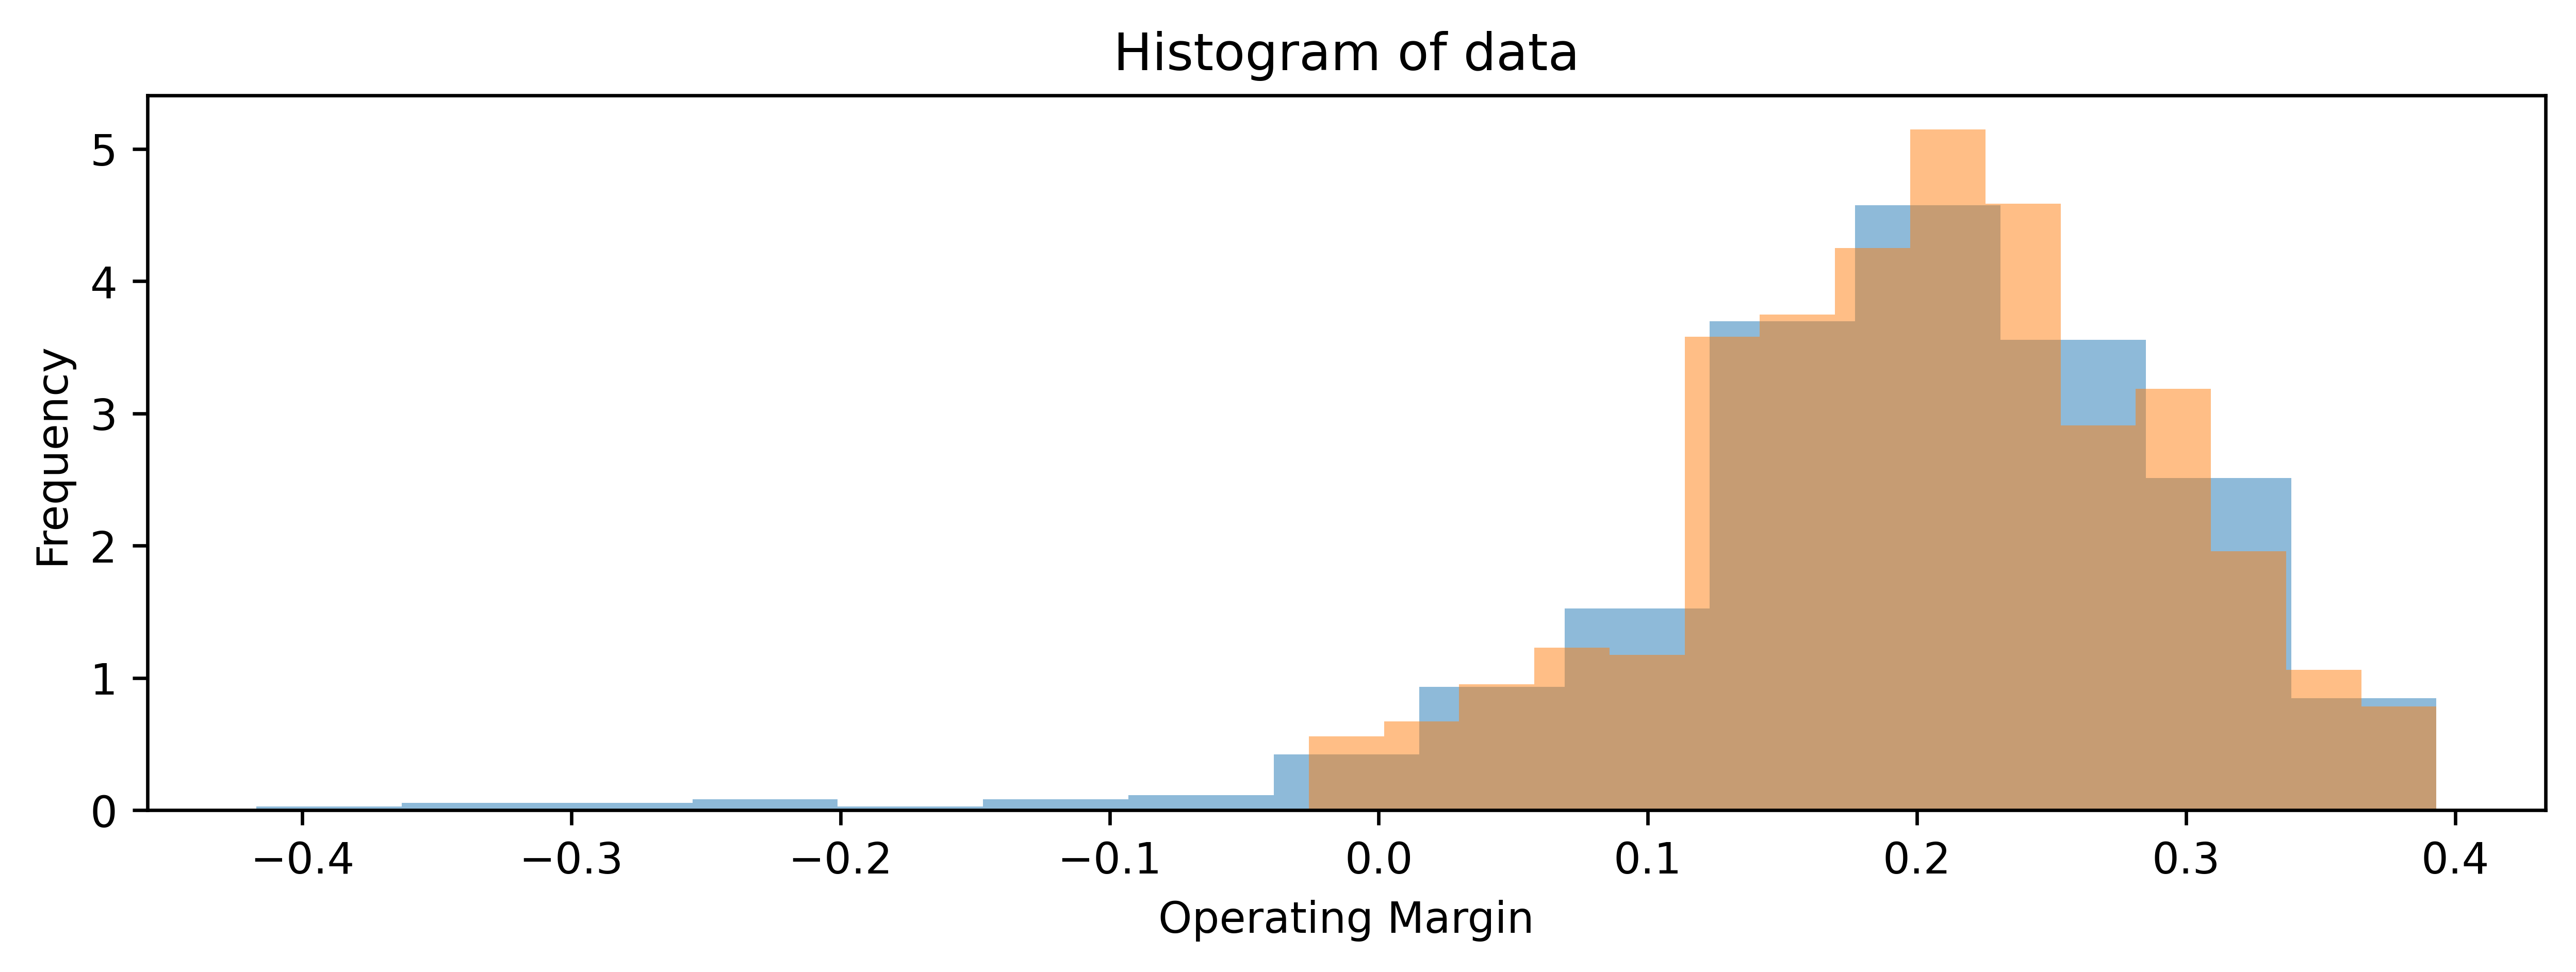

In [6]:
def remove_outliers(stacked_df):
    Q1 = stacked_df.quantile(0.25)
    Q3 = stacked_df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return stacked_df[stacked_df.between(lower_bound, upper_bound)]

# Stack frame for plotting ease
stacked_df = ROA_df.stack()
stacked_df_no_outliers = remove_outliers(stacked_df)

fig, axes = plt.subplots(1, 1, figsize=(10, 3), dpi=600)
hist_options = {
    "bins": 15,
    "alpha": 0.5,
    "density": True, # Nomalize (AUC=1) so shapes are comparable
}
axes.hist(stacked_df, label="Data with outliers", **hist_options)
axes.hist(stacked_df_no_outliers, label="Data without outliers", **hist_options)
axes.set_title("Histogram of data")
axes.set_xlabel(f"{name_of_metric}")
axes.set_ylabel("Frequency")
plt.show()

### Step 4
[Steps backlink](#steps)

### Step 5
[Steps backlink](#steps)

### Step 6
[Steps backlink](#steps)

### Step 7
[Steps backlink](#steps)

### Step 8
[Steps backlink](#steps)

### Step 9
[Steps backlink](#steps)

### Step 10
[Steps backlink](#steps)

### Step 11
[Steps backlink](#steps)

### Step 12
[Steps backlink](#steps)

### Step 13
[Steps backlink](#steps)

### Step 14
[Steps backlink](#steps)